In [1]:
%config InlineBackend.close_figures = False

In [2]:
from zardoz.rt.weapons import WeaponClass, WeaponType, DamageType, Craftsmanship, ItemAvailability, Weapon, WeaponInstance
from zardoz.rt.combat import AimFull, FullAutoBurst, ExtraHitsBonus, SemiAutoBurst

In [27]:
WeaponType['Las']

<WeaponType.Las: 1>

In [3]:
from zardoz.utils import d100

In [4]:
import seaborn as sns

In [5]:
import random
import dice
import math
import statistics
import pandas as pd
import matplotlib as mpl
import ficus

In [6]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [7]:
ripper_model = Weapon(
    name='Ripper Pistol',
    availability=ItemAvailability.Scarce,
    weapon_class=WeaponClass.Pistol,
    weapon_type=WeaponType.Las,
    weapon_range=30,
    rof=(True, 2, 0),
    damage_roll=1,
    damage_bonus=3,
    damage_type=DamageType.Rending,
    pen=5,
    clip=8,
    reload_time=1,
    mass=2
)

dervish_model = Weapon(
    name='Mark IV Dervish',
    availability=ItemAvailability.Scarce,
    weapon_class=WeaponClass.Pistol,
    weapon_type=WeaponType.Las,
    weapon_range=25,
    rof=(True, 4, 0),
    damage_roll=1,
    damage_bonus=3,
    damage_type=DamageType.Energy,
    pen=0,
    clip=20,
    reload_time=1,
    mass=2
)

inferno_model = Weapon(
    name = 'Inferno Pistol',
    availability=ItemAvailability.Scarce,
    weapon_class=WeaponClass.Pistol,
    weapon_type=WeaponType.Melta,
    weapon_range=10,
    rof=(True, 0, 0),
    damage_roll=2,
    damage_bonus=8,
    damage_type=DamageType.Energy,
    pen=13,
    clip=3,
    reload_time=1,
    mass=3
)

stutter_model = Weapon(
    name = 'Stutter-las',
    availability=ItemAvailability.Scarce,
    weapon_class=WeaponClass.Pistol,
    weapon_type=WeaponType.Las,
    weapon_range=35,
    rof=(True, 0, 5),
    damage_roll=1,
    damage_bonus=2,
    damage_type=DamageType.Energy,
    pen=0,
    clip=25,
    reload_time=1,
    mass=3
)

In [8]:
ripper_instance = WeaponInstance(ripper_model, craftsmanship=Craftsmanship.Best)
inferno_instance = WeaponInstance(inferno_model, craftsmanship=Craftsmanship.Good)
dervish_instance = WeaponInstance(dervish_model, craftsmanship=Craftsmanship.Good)
stutter_instance = WeaponInstance(stutter_model, craftsmanship=Craftsmanship.Good)

In [32]:
stutter_instance._attack(35, actions=[], target_range=1, quiet=False)

Point blank: +30
final test: 35 + 30
rolled 12 for 5 degrees


UnboundLocalError: local variable 'hits_max' referenced before assignment

In [37]:
def simulate_attack(instance, BS, target_range, actions, N=10000):
    damages, tests = [], []
    for _ in range(N):
        dmg, test, _, _, _, _ = instance._attack(BS, actions=actions, target_range=target_range)
        damages.append(dmg)
        tests.append(test)
    return pd.DataFrame({'damage': damages, 'test': tests})

In [38]:
def simulate_and_plot(weapon_instance, BS, target_range, actions=[], N=100000):
    damages = simulate_attack(weapon_instance, BS, target_range, actions, N=N)
    sr = sum(damages.damage > 0) / N
    maxd = damages.damage.max()
    medd = damages.damage[damages['damage'] > 0].median()

    sns.set_style('ticks')
    with ficus.FigureManager(show=True, figsize=(12,8), filename=f'BS{BS}_{weapon_instance.name}_R{target_range}_.png') as (fig, ax):
        sns.kdeplot(data=damages[damages['damage'] != 0], x='damage', fill=True, ax=ax)
        sns.despine(ax=ax, offset=10)
        ax.set_xlabel('Damage')
        ax.set_title(f'{weapon_instance.name}, {[action.name for action in actions]}, BS={BS}, Range={target_range}\nN={N:,} ({sr:4f} SR), Max={maxd}, Med={medd}')

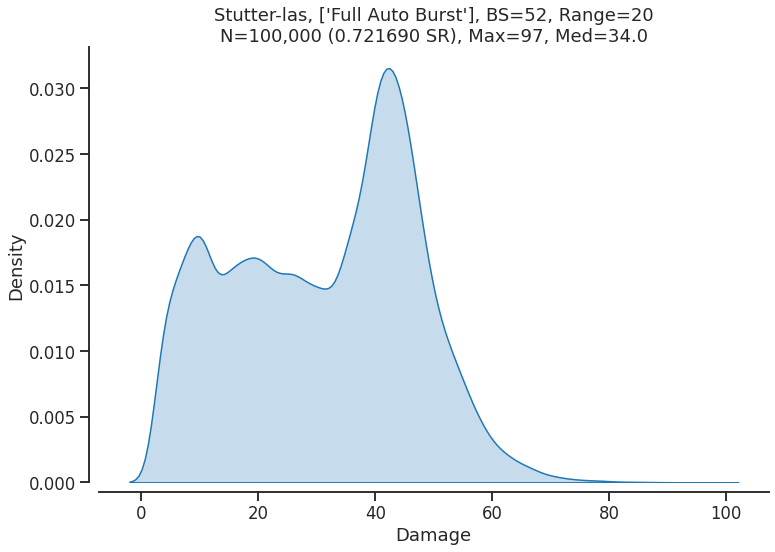

In [39]:
simulate_and_plot(stutter_instance, 52, 20, actions=[FullAutoBurst])

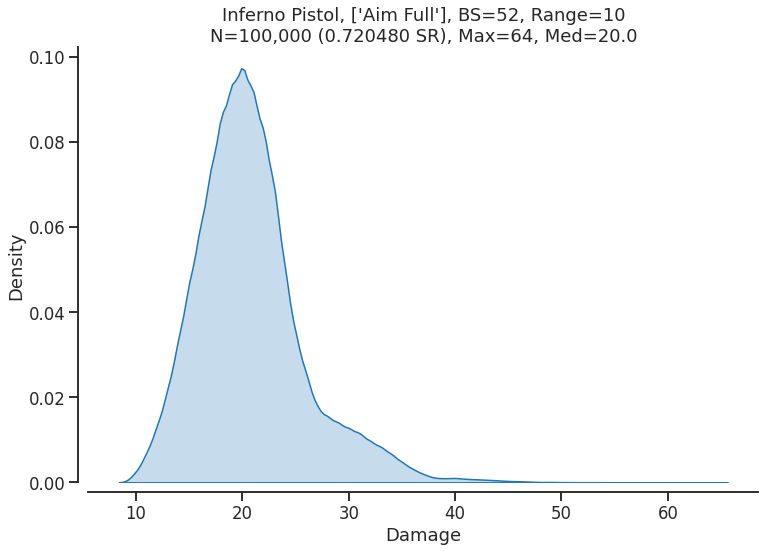

In [40]:
simulate_and_plot(inferno_instance, 52, 10, actions=[AimFull])

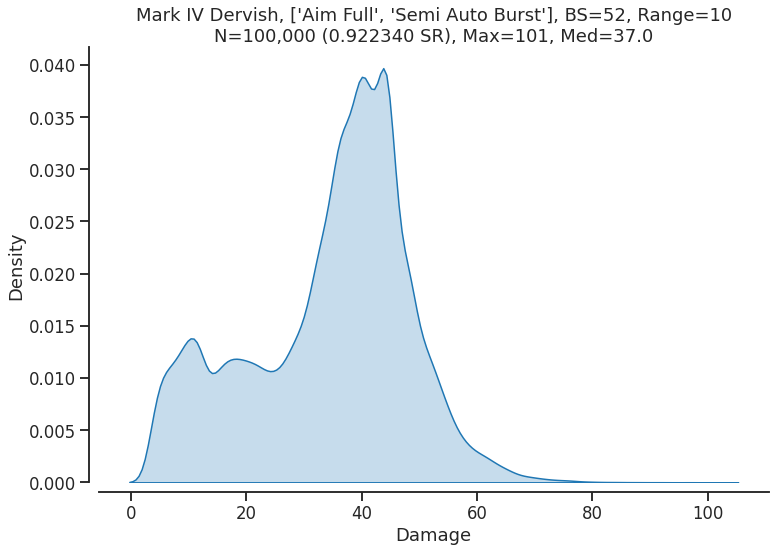

In [41]:
simulate_and_plot(dervish_instance, 52, 10, [AimFull, SemiAutoBurst])

In [48]:
def plot_compare_weapons(weapon_a, weapon_b, BS, target_range, actions_a=[], actions_b=[], N=100000):
    damages_a = simulate_attack(weapon_a, BS, target_range, actions_a, N=N)
    damages_a['Weapon'] = weapon_a.name
    damages_b = simulate_attack(weapon_b, BS, target_range, actions_b, N=N)
    damages_b['Weapon'] = weapon_b.name
    
    damages = pd.concat((damages_a, damages_b))
    
    sr_a = sum(damages_a.damage > 0) / N
    sr_b = sum(damages_b.damage > 0) / N

    maxd_a = damages_a.damage.max()
    maxd_b = damages_a.damage.max()

    medd_a = damages_a.damage[damages_a['damage'] > 0].median()
    medd_b = damages_b.damage[damages_b['damage'] > 0].median()
    
    actions_a_str = ', '.join([action.name for action in actions_a])
    actions_b_str = ', '.join([action.name for action in actions_b])
    
    title = f'{weapon_a.name} @ {actions_a_str}; SR={sr_a:4f}, Max={maxd_a}, Med={medd_a}\n'\
            f'{weapon_b.name} @ {actions_b_str}; SR={sr_b:4f}, Max={maxd_b}, Med={medd_b}\n'\
            f'BS={BS}, Range={target_range}, N={N:,}'
    
    sns.set_style('ticks')
    with ficus.FigureManager(show=True, figsize=(12,8), filename=f'BS{BS}_{weapon_a.name}v{weapon_b.name}_R{target_range}_.png') as (fig, ax):
        sns.kdeplot(data=damages[damages['damage'] != 0], x='damage', hue='Weapon',  fill=True, ax=ax)
        sns.despine(ax=ax, offset=10)
        ax.set_xlabel('Damage')
        ax.set_title(title)

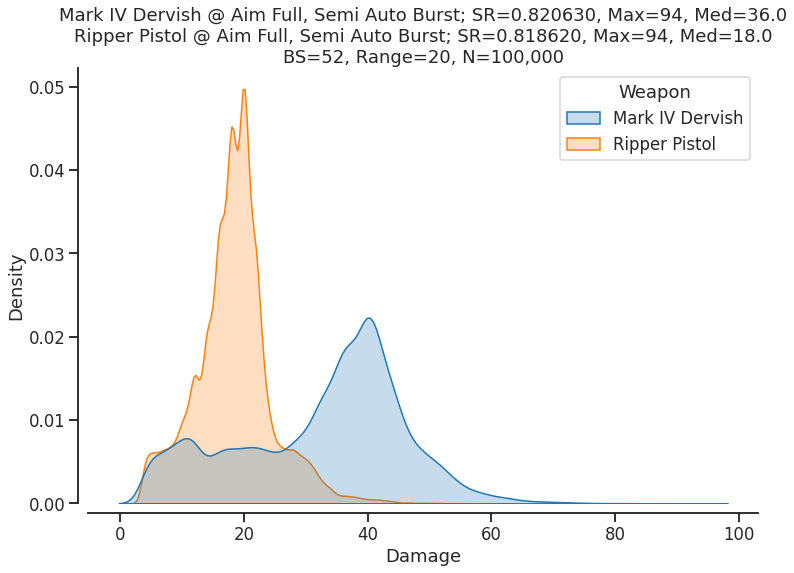

In [51]:
plot_compare_weapons(dervish_instance, ripper_instance, 52, 20, actions_a=[AimFull, SemiAutoBurst], actions_b=[AimFull, SemiAutoBurst])

In [40]:
results = []

N = 10000
for BS in range(20, 60, 2):
    for _ in range(N):
        dmg, test, _, _, _, _ = instance._attack(BS, FullAutoBurst, target_range=20)
        results.append((BS, dmg, test))
data = pd.DataFrame(results, columns=['BS', 'Damage', 'TS'])

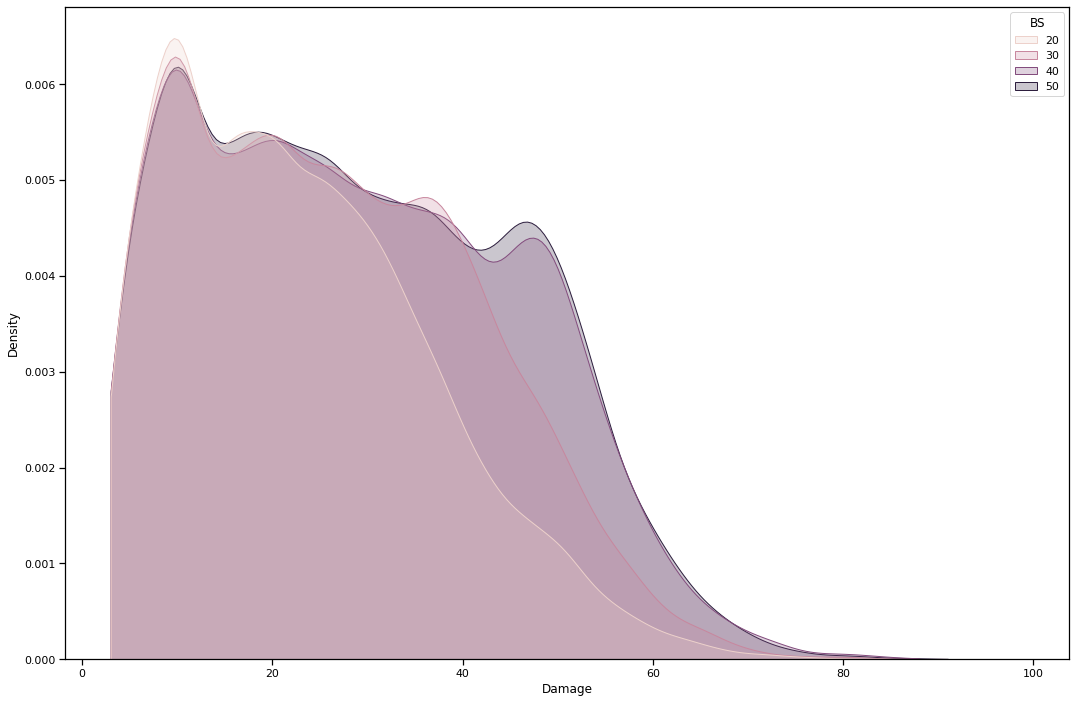

In [38]:
with FigureManager(show=True) as (fig, ax):
    hits = data['Damage'] != 0
    sns.kdeplot(data=data[hits], x='Damage', hue='BS',  fill=True, cut=0, ax=ax)

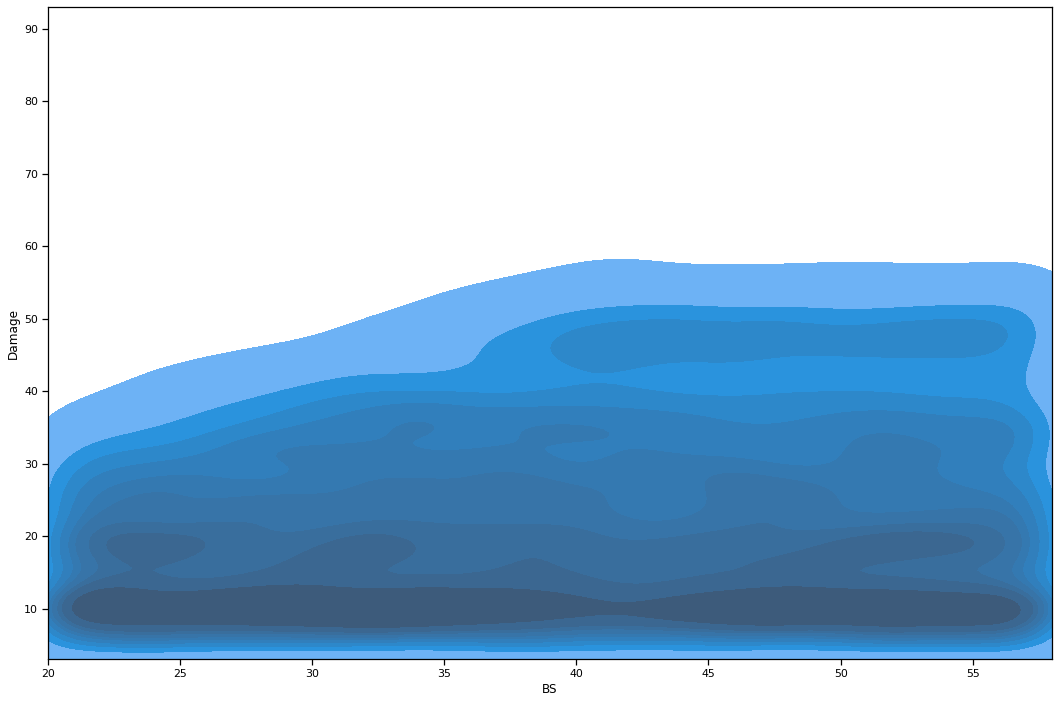

In [42]:
with FigureManager(show=True) as (fig, ax):
    hits = data['Damage'] != 0
    sns.kdeplot(data=data[hits], y='Damage', x='BS',  fill=True, cut=0, ax=ax)

<ipython-input-50-d7b10d88cd3b>:4: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  ax.figure.savefig('BS30_R20_Stutterlas.jpeg', format='jpeg', quality=95)


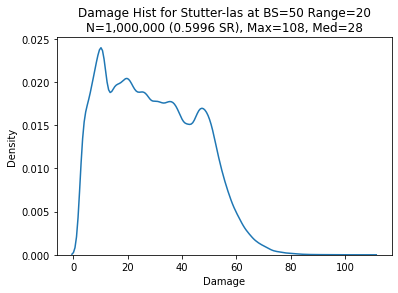

In [50]:
ax = sns.kdeplot(successes)
ax.set_xlabel('Damage')
ax.set_title(f'Damage Hist for Stutter-las at BS=50 Range=20\nN={N:,} ({len(successes) / (fails+len(successes)):.4f} SR), Max={max(successes)}, Med={int(statistics.median(successes))}')
ax.figure.savefig('BS30_R20_Stutterlas.jpeg', format='jpeg', quality=95)

In [ ]:
successes = []
ratios = []

for BS in range(1,100,5):
    for _ in range(100000):
        dmg, _, _, _, _ = instance._attack(70, FullAutoBurst, target_range=20)
        if not dmg:
            fails += 1
        else:
            successes.append(dmg)

In [13]:
%timeit random.randint(1, 100)

762 ns ± 59 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [15]:
%timeit dice.roll('1d100')

2.15 ms ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit instance._attack(35, FullAutoBurst, target_range=20)

7.25 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit instance._attack(35, FullAutoBurst, target_range=20)

9.74 µs ± 566 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [2]:
import pandas as pd

In [4]:
df = pd.read_table('/home/camille/Downloads/Rogue Trader Combined Spreadsheet - Weapons.tsv')
df = df.where(pd.notnull(df), None)

In [31]:
def int_entry(entry):
    if entry == '-' or entry is None:
        return 0
    else:
        try:
            return int(entry.strip())
        except:
            return entry.strip()

In [32]:
data = []
for idx, row in df.iterrows():
    item = {}
    item['name'] = row['Name'].strip()

    klasses = row['Weapon Class'].split('/')
    item['weapon_class'] = [WeaponClass[k.strip()] for k in klasses]
    
    types = row['Weapon Type'].split('/')
    item['weapon_type'] = [WeaponType[t.strip()] for t in types]
    
    item['weapon_range'] = row['Range'] if row['Range'] is not None else 0.0
    if row['RoF'] is not None:
        tokens = [t.strip() for t in row['RoF'].strip().split('/')]
        if len(tokens) == 3:
            tokens[0] = True if tokens[0] == 'S' else False
            tokens[1] = int(tokens[1]) if tokens[1] != '-' else None
            tokens[2] = int(tokens[2]) if tokens[2] != '-' else None
            item['rof'] = tuple(tokens)
        else:
            item['rof'] = None
    else:
        item['rof'] = None
    
    item['damage_roll'] = '1d' + row['Nd10'].strip() if row['Nd10'] else None
    item['damage_bonus'] = int(row['Bonus']) if row['Bonus'] is not None and row['Bonus'] != '-' else 0
    item['penetration'] = int_entry(row['Pen'])
    
    data.append(item)

In [33]:
data

[{'name': 'Archeotech Laspistol',
  'weapon_class': [<WeaponClass.Pistol: 1>],
  'weapon_type': [<WeaponType.Las: 1>],
  'weapon_range': 90.0,
  'rof': (True, 3, None),
  'damage_roll': '1d1',
  'damage_bonus': 3,
  'penetration': 2},
 {'name': 'Belasco Dueling Pistol',
  'weapon_class': [<WeaponClass.Pistol: 1>],
  'weapon_type': [<WeaponType.Las: 1>],
  'weapon_range': 45.0,
  'rof': (True, None, None),
  'damage_roll': '1d1',
  'damage_bonus': 5,
  'penetration': 4},
 {'name': 'Clovis "Twist" Pistol',
  'weapon_class': [<WeaponClass.Pistol: 1>],
  'weapon_type': [<WeaponType.Las: 1>],
  'weapon_range': 20.0,
  'rof': (True, None, None),
  'damage_roll': '1d1',
  'damage_bonus': 4,
  'penetration': 0},
 {'name': 'Hellpistol (Lucius Pattern)',
  'weapon_class': [<WeaponClass.Pistol: 1>],
  'weapon_type': [<WeaponType.Las: 1>],
  'weapon_range': 35.0,
  'rof': (True, 2, None),
  'damage_roll': '1d1',
  'damage_bonus': 4,
  'penetration': 7},
 {'name': 'Las Gauntlets',
  'weapon_class':

In [6]:
from dataclasses import dataclass

In [16]:
@dataclass(frozen=True)
class Test:
    x: int = 1
    y: int = 2

In [39]:
class Coordinates(Test):
    def __init__(self, z, **kwargs):
        self.z = z
        super().__init__(**kwargs)
    
    def test(self):
        yield 1
        yield 2

In [40]:
c = Coordinates(10, x=5, y=7)

In [34]:
33 // 10

3

In [38]:
str(WeaponType.Las)

'WeaponType.Las'

In [45]:
for t in c.test():
    print (t)

1
2


In [46]:
from fuzzy_types.fuzzy import FuzzyDict

In [47]:
f = FuzzyDict({'Weapon Skill': 13, 'Ballistic Skill': 12, 'Agility': 20})

In [50]:
f['Weapon     Skill']

13

In [69]:
class A:
    def __init__(self, src, **kwargs):
        print('A from', src)
        super().__init__('A', **kwargs)

class B(A):
    def __init__(self, src, **kwargs):
        print('B from', src)
        super().__init__('B', **kwargs)

class C:
    def __init__(self, src, **kwargs):
        print('C from', src)
        super().__init__('C', **kwargs)
        
class D(B, C):
    def __init__(self, **kwargs):
        print('D')
        super().__init__('D', **kwargs)

In [85]:
D()

D
B from D
A from B
C from A


TypeError: object.__init__() takes exactly one argument (the instance to initialize)

In [86]:
l = [4,3,5,6]

In [89]:
l.index(min(l))

1